# Neural Networks for MNIST dataset

In [1]:
import pandas as pd
from boosting_nn import *
X, Y = parse_spambase_data("data/tiny.spam.train")
X[0]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  1.52,  0.  ,  2.29,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.76,  0.76,
        0.76,  0.  ,  2.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        3.85, 19.  , 77.  ])

In [30]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np

In [29]:
from torch.optim.lr_scheduler import StepLR

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [4]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [5]:
batch_size = 32
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [6]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [7]:
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Looking are images

In [8]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [9]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(32, 1, 28, 28)

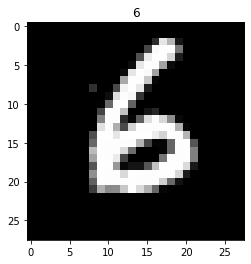

In [10]:
show(X[0][0], Y[0])

In [11]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296  0.12310111  2.5032809
   1.8795974  -0.15692005 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.424212

## Feed Forward Neural Network

In [12]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net #.cuda()

In [13]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    for epoch in range(num_epochs):
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28) #.cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
        
    return val_acc, val_loss, train_loss

In [14]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  #.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

In [15]:
net = get_model()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(6.72, 2.342579137420654)

In [16]:
val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.3337
Epoch [1/2], Valid Accuracy: 92.3900, Valid Loss: 0.2754
Epoch [2/2], Loss: 0.2596
Epoch [2/2], Valid Accuracy: 94.0800, Valid Loss: 0.2318


## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [17]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Models with Dropout

In [18]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules) #.cuda()

In [19]:
net = get_model_v2(M = 300, p=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [20]:
train_model(train_loader, test_loader, num_epochs=4, model=net, optimizer=optimizer)

Epoch [1/4], Loss: 0.4129
Epoch [1/4], Valid Accuracy: 91.7700, Valid Loss: 0.3037
Epoch [2/4], Loss: 0.2655
Epoch [2/4], Valid Accuracy: 92.4300, Valid Loss: 0.2850
Epoch [3/4], Loss: 0.2551
Epoch [3/4], Valid Accuracy: 93.7700, Valid Loss: 0.2913
Epoch [4/4], Loss: 0.2458
Epoch [4/4], Valid Accuracy: 94.4700, Valid Loss: 0.2487


(94.47, 0.24871792750116437, 0.24582692833407782)

# 1.Experiment with learning rate

In [21]:
nb_epochs = 10
lr_vals = []
for learning_rate in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    net = get_model()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                num_epochs=nb_epochs, 
                                                model=net, optimizer=optimizer)
    lr_vals.append([learning_rate, val_acc])

Epoch [1/10], Loss: 47.4950
Epoch [1/10], Valid Accuracy: 11.9600, Valid Loss: 2.4677
Epoch [2/10], Loss: 5.6097
Epoch [2/10], Valid Accuracy: 10.3300, Valid Loss: 2.4385
Epoch [3/10], Loss: 2.4050
Epoch [3/10], Valid Accuracy: 9.0000, Valid Loss: 2.4443
Epoch [4/10], Loss: 2.4010
Epoch [4/10], Valid Accuracy: 9.9000, Valid Loss: 2.5220
Epoch [5/10], Loss: 2.4096
Epoch [5/10], Valid Accuracy: 11.4300, Valid Loss: 2.4723
Epoch [6/10], Loss: 2.4083
Epoch [6/10], Valid Accuracy: 9.6600, Valid Loss: 2.4978
Epoch [7/10], Loss: 2.4050
Epoch [7/10], Valid Accuracy: 10.3500, Valid Loss: 2.4794
Epoch [8/10], Loss: 2.4061
Epoch [8/10], Valid Accuracy: 9.8800, Valid Loss: 2.4928
Epoch [9/10], Loss: 2.4043
Epoch [9/10], Valid Accuracy: 9.9000, Valid Loss: 2.6087
Epoch [10/10], Loss: 2.4097
Epoch [10/10], Valid Accuracy: 9.0000, Valid Loss: 2.4832
Epoch [1/10], Loss: 2.6115
Epoch [1/10], Valid Accuracy: 13.6500, Valid Loss: 2.2728
Epoch [2/10], Loss: 2.2901
Epoch [2/10], Valid Accuracy: 10.2100, Va

In [23]:
df_lr = pd.DataFrame(lr_vals,columns=['learning_rate','validation_accuracy'])
df_lr

,learning_rate,validation_accuracy
0,1.00000,9.00
1,0.10000,11.35
2,0.01000,94.02
3,0.00100,97.48
4,0.00010,97.89
5,0.00001,93.83


Best learning rate comes in between 0.001 to 0.0001 with validation accuracy of 97.89

# 2. Experiment with hidden layer

In [29]:
nb_epochs = 10
learning_rate = 0.01
hidden_vals = []
for hidden_layer in [10, 50, 100, 300, 1000, 1200,1500, 1800, 2000]:
    net = get_model(hidden_layer)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                num_epochs=nb_epochs, 
                                                model=net, optimizer=optimizer)
    hidden_vals.append([hidden_layer, train_loss, val_acc])

Epoch [1/10], Loss: 0.5061
Epoch [1/10], Valid Accuracy: 86.8500, Valid Loss: 0.4422
Epoch [2/10], Loss: 0.4120
Epoch [2/10], Valid Accuracy: 85.7100, Valid Loss: 0.4792
Epoch [3/10], Loss: 0.3970
Epoch [3/10], Valid Accuracy: 88.3500, Valid Loss: 0.4151
Epoch [4/10], Loss: 0.3949
Epoch [4/10], Valid Accuracy: 87.1500, Valid Loss: 0.4450
Epoch [5/10], Loss: 0.3875
Epoch [5/10], Valid Accuracy: 89.3800, Valid Loss: 0.3909
Epoch [6/10], Loss: 0.3852
Epoch [6/10], Valid Accuracy: 87.5400, Valid Loss: 0.4306
Epoch [7/10], Loss: 0.3839
Epoch [7/10], Valid Accuracy: 89.2700, Valid Loss: 0.3870
Epoch [8/10], Loss: 0.3874
Epoch [8/10], Valid Accuracy: 89.2100, Valid Loss: 0.3829
Epoch [9/10], Loss: 0.3836
Epoch [9/10], Valid Accuracy: 87.2500, Valid Loss: 0.4423
Epoch [10/10], Loss: 0.3795
Epoch [10/10], Valid Accuracy: 86.1000, Valid Loss: 0.4862
Epoch [1/10], Loss: 0.3375
Epoch [1/10], Valid Accuracy: 93.1400, Valid Loss: 0.2553
Epoch [2/10], Loss: 0.2699
Epoch [2/10], Valid Accuracy: 93.300

In [30]:
df_hidden = pd.DataFrame(hidden_vals,columns=['hidden_layer','train_loss','val_acc'])
df_hidden

,hidden_layer,train_loss,val_acc
0,10,0.379495,86.10
1,50,0.234484,94.02
2,100,0.228299,93.69
3,300,0.214108,94.32
4,1000,0.212705,93.94
5,1200,0.220094,94.73
6,1500,0.218760,93.64
7,1800,0.201601,94.67
8,2000,0.221524,94.47


Best size for hidden layer comes in between 1000 and 1200 at around 94.7% validation accuracy. Train loss is less for some models but validation accuracy is higher. Hence some of these models overfit.

# 3. Experiment with weight decay

In [21]:
nb_epochs = 20
learning_rate = 0.001
wd_vals = []
for wd in [0,0.0001,0.001,0.01,0.1,0.3]:
    net = get_model(M=300)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = wd)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                num_epochs=nb_epochs, 
                                                model=net, optimizer=optimizer)
    wd_vals.append([wd, train_loss, val_loss, val_acc])

Epoch [1/20], Loss: 0.2029
Epoch [1/20], Valid Accuracy: 96.4100, Valid Loss: 0.1131
Epoch [2/20], Loss: 0.0872
Epoch [2/20], Valid Accuracy: 97.3800, Valid Loss: 0.0829
Epoch [3/20], Loss: 0.0624
Epoch [3/20], Valid Accuracy: 97.4400, Valid Loss: 0.0818
Epoch [4/20], Loss: 0.0485
Epoch [4/20], Valid Accuracy: 97.5300, Valid Loss: 0.0864
Epoch [5/20], Loss: 0.0386
Epoch [5/20], Valid Accuracy: 97.8400, Valid Loss: 0.0767
Epoch [6/20], Loss: 0.0323
Epoch [6/20], Valid Accuracy: 97.7000, Valid Loss: 0.0959
Epoch [7/20], Loss: 0.0290
Epoch [7/20], Valid Accuracy: 97.8900, Valid Loss: 0.0798
Epoch [8/20], Loss: 0.0246
Epoch [8/20], Valid Accuracy: 97.7200, Valid Loss: 0.0912
Epoch [9/20], Loss: 0.0214
Epoch [9/20], Valid Accuracy: 97.5200, Valid Loss: 0.1175
Epoch [10/20], Loss: 0.0185
Epoch [10/20], Valid Accuracy: 97.7200, Valid Loss: 0.1181
Epoch [11/20], Loss: 0.0199
Epoch [11/20], Valid Accuracy: 97.8100, Valid Loss: 0.1093
Epoch [12/20], Loss: 0.0182
Epoch [12/20], Valid Accuracy: 97

Epoch [16/20], Valid Accuracy: 90.3000, Valid Loss: 0.4349
Epoch [17/20], Loss: 0.4673
Epoch [17/20], Valid Accuracy: 90.1700, Valid Loss: 0.4439
Epoch [18/20], Loss: 0.4673
Epoch [18/20], Valid Accuracy: 89.1600, Valid Loss: 0.4536
Epoch [19/20], Loss: 0.4676
Epoch [19/20], Valid Accuracy: 90.2600, Valid Loss: 0.4434
Epoch [20/20], Loss: 0.4669
Epoch [20/20], Valid Accuracy: 90.2600, Valid Loss: 0.4457
Epoch [1/20], Loss: 0.8734
Epoch [1/20], Valid Accuracy: 82.8400, Valid Loss: 0.8193
Epoch [2/20], Loss: 0.8438
Epoch [2/20], Valid Accuracy: 82.2700, Valid Loss: 0.8268
Epoch [3/20], Loss: 0.8349
Epoch [3/20], Valid Accuracy: 85.0300, Valid Loss: 0.7943
Epoch [4/20], Loss: 0.8318
Epoch [4/20], Valid Accuracy: 81.2600, Valid Loss: 0.8097
Epoch [5/20], Loss: 0.8243
Epoch [5/20], Valid Accuracy: 83.3400, Valid Loss: 0.8314
Epoch [6/20], Loss: 0.8234
Epoch [6/20], Valid Accuracy: 85.5100, Valid Loss: 0.7892
Epoch [7/20], Loss: 0.8203
Epoch [7/20], Valid Accuracy: 84.9100, Valid Loss: 0.778

In [22]:
df_wd = pd.DataFrame(wd_vals,columns=['weight_decay','train_loss','val_loss','val_acc'])
df_wd

,weight_decay,train_loss,val_loss,val_acc
0,0.0000,0.013918,0.157546,97.93
1,0.0001,0.023511,0.087758,97.93
2,0.0010,0.063317,0.088269,97.22
3,0.0100,0.165440,0.155607,95.63
4,0.1000,0.466870,0.445706,90.26
5,0.3000,0.815593,0.783258,85.70


Best value of weight decay parameter is around 0.0001. We observe a train loss of 0.023, validation loss of 0.088 and validation accuracy of 97.93%

# 4. Experiment with dropout

In [23]:
nb_epochs = 20
learning_rate = 0.001
p_vals = []
for p in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    net = get_model_v2(M = 300, p=p)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    model_accuracy_loss(net, test_loader)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                                num_epochs=nb_epochs, 
                                                model=net, optimizer=optimizer)
    p_vals.append([p, train_loss, val_loss, val_acc])

Epoch [1/20], Loss: 0.2003
Epoch [1/20], Valid Accuracy: 96.9600, Valid Loss: 0.0957
Epoch [2/20], Loss: 0.0890
Epoch [2/20], Valid Accuracy: 97.5500, Valid Loss: 0.0831
Epoch [3/20], Loss: 0.0612
Epoch [3/20], Valid Accuracy: 97.7400, Valid Loss: 0.0799
Epoch [4/20], Loss: 0.0478
Epoch [4/20], Valid Accuracy: 97.5700, Valid Loss: 0.0841
Epoch [5/20], Loss: 0.0384
Epoch [5/20], Valid Accuracy: 97.4200, Valid Loss: 0.0970
Epoch [6/20], Loss: 0.0341
Epoch [6/20], Valid Accuracy: 97.9000, Valid Loss: 0.0879
Epoch [7/20], Loss: 0.0268
Epoch [7/20], Valid Accuracy: 97.5500, Valid Loss: 0.1005
Epoch [8/20], Loss: 0.0268
Epoch [8/20], Valid Accuracy: 98.0500, Valid Loss: 0.0884
Epoch [9/20], Loss: 0.0211
Epoch [9/20], Valid Accuracy: 97.9300, Valid Loss: 0.0964
Epoch [10/20], Loss: 0.0210
Epoch [10/20], Valid Accuracy: 97.6500, Valid Loss: 0.1096
Epoch [11/20], Loss: 0.0204
Epoch [11/20], Valid Accuracy: 98.0300, Valid Loss: 0.0953
Epoch [12/20], Loss: 0.0178
Epoch [12/20], Valid Accuracy: 97

Epoch [16/20], Valid Accuracy: 97.8300, Valid Loss: 0.1350
Epoch [17/20], Loss: 0.0187
Epoch [17/20], Valid Accuracy: 97.7700, Valid Loss: 0.1501
Epoch [18/20], Loss: 0.0142
Epoch [18/20], Valid Accuracy: 97.8700, Valid Loss: 0.1575
Epoch [19/20], Loss: 0.0157
Epoch [19/20], Valid Accuracy: 97.8600, Valid Loss: 0.1535
Epoch [20/20], Loss: 0.0134
Epoch [20/20], Valid Accuracy: 97.7900, Valid Loss: 0.1462
Epoch [1/20], Loss: 0.2971
Epoch [1/20], Valid Accuracy: 96.2400, Valid Loss: 0.1291
Epoch [2/20], Loss: 0.0982
Epoch [2/20], Valid Accuracy: 96.5600, Valid Loss: 0.1034
Epoch [3/20], Loss: 0.0691
Epoch [3/20], Valid Accuracy: 97.0600, Valid Loss: 0.0945
Epoch [4/20], Loss: 0.0534
Epoch [4/20], Valid Accuracy: 97.5100, Valid Loss: 0.0836
Epoch [5/20], Loss: 0.0407
Epoch [5/20], Valid Accuracy: 97.8100, Valid Loss: 0.0850
Epoch [6/20], Loss: 0.0334
Epoch [6/20], Valid Accuracy: 97.7600, Valid Loss: 0.0881
Epoch [7/20], Loss: 0.0303
Epoch [7/20], Valid Accuracy: 97.7200, Valid Loss: 0.089

Epoch [12/20], Loss: 0.0187
Epoch [12/20], Valid Accuracy: 97.7000, Valid Loss: 0.1165
Epoch [13/20], Loss: 0.0165
Epoch [13/20], Valid Accuracy: 97.7100, Valid Loss: 0.1207
Epoch [14/20], Loss: 0.0191
Epoch [14/20], Valid Accuracy: 97.8600, Valid Loss: 0.1218
Epoch [15/20], Loss: 0.0139
Epoch [15/20], Valid Accuracy: 97.7600, Valid Loss: 0.1365
Epoch [16/20], Loss: 0.0141
Epoch [16/20], Valid Accuracy: 97.8500, Valid Loss: 0.1364
Epoch [17/20], Loss: 0.0150
Epoch [17/20], Valid Accuracy: 97.9400, Valid Loss: 0.1334
Epoch [18/20], Loss: 0.0133
Epoch [18/20], Valid Accuracy: 97.7600, Valid Loss: 0.1310
Epoch [19/20], Loss: 0.0130
Epoch [19/20], Valid Accuracy: 97.7200, Valid Loss: 0.1654
Epoch [20/20], Loss: 0.0145
Epoch [20/20], Valid Accuracy: 97.8100, Valid Loss: 0.1311


In [25]:
df_p = pd.DataFrame(p_vals,columns=['dropout_rate','train_loss','val_loss','val_acc'])
df_p

,dropout_rate,train_loss,val_loss,val_acc
0,0.0,0.014709,0.143801,97.96
1,0.1,0.011449,0.132509,98.00
2,0.2,0.014694,0.112719,98.10
3,0.3,0.011582,0.146683,98.10
4,0.4,0.013434,0.146249,97.79
5,0.5,0.015365,0.155703,97.83
6,0.6,0.013899,0.135189,98.18
7,0.7,0.014302,0.138620,98.03
8,0.8,0.012599,0.150708,98.15
9,0.9,0.014500,0.131142,97.81


Best dropout rate is observed at 0.6 with validation accuracy of 98.18%, train loss of 0.014 and validation loss of 0.013. </br>
Dropout helps model learn sparse representation due to the random drop in neurons during training(Sparse activation). We randomly drop weights randomly during training which makes Also since it is a regularization technique it works by decreasing variance at the cost of increasing bias.   </br>
Compared to L2 weight decay dropout performs better as we have higher validation accuracy for dropout in comparison to L2 regularization (97.9%) 

In [26]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    for epoch in range(num_epochs):
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28) #.cuda()
        
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
        scheduler.step()
    return val_acc, val_loss, train_loss

In [31]:
nb_epochs = 20
learning_rate = 0.001
p = 0.6

net = get_model_v2(M = 300, p=p)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
model_accuracy_loss(net, test_loader)
val_acc, val_loss, train_loss = train_model(train_loader, test_loader, 
                                            num_epochs=nb_epochs, 
                                            model=net, optimizer=optimizer)

Epoch [1/20], Loss: 0.3415
Epoch [1/20], Valid Accuracy: 95.7200, Valid Loss: 0.1352
Epoch [2/20], Loss: 0.1031
Epoch [2/20], Valid Accuracy: 97.2300, Valid Loss: 0.0917
Epoch [3/20], Loss: 0.0726
Epoch [3/20], Valid Accuracy: 97.3200, Valid Loss: 0.0883
Epoch [4/20], Loss: 0.0538
Epoch [4/20], Valid Accuracy: 97.4600, Valid Loss: 0.0903
Epoch [5/20], Loss: 0.0420
Epoch [5/20], Valid Accuracy: 97.7000, Valid Loss: 0.0773
Epoch [6/20], Loss: 0.0345
Epoch [6/20], Valid Accuracy: 97.8900, Valid Loss: 0.0766
Epoch [7/20], Loss: 0.0301
Epoch [7/20], Valid Accuracy: 97.8900, Valid Loss: 0.0903
Epoch [8/20], Loss: 0.0243
Epoch [8/20], Valid Accuracy: 97.7100, Valid Loss: 0.0927
Epoch [9/20], Loss: 0.0233
Epoch [9/20], Valid Accuracy: 97.7300, Valid Loss: 0.1007
Epoch [10/20], Loss: 0.0225
Epoch [10/20], Valid Accuracy: 97.9400, Valid Loss: 0.0985
Epoch [11/20], Loss: 0.0062
Epoch [11/20], Valid Accuracy: 98.4100, Valid Loss: 0.0768
Epoch [12/20], Loss: 0.0021
Epoch [12/20], Valid Accuracy: 98

In [32]:
val_acc, val_loss, train_loss

(98.4, 0.08779270153171959, 0.0001131848096149767)

Using a stepLR scheduler improves the model performance as the validation accuracy improves by from 98.18% to 98.4%. 